# Application: Learning optimal restrictions in a continuous-action game

This notebook corresponds to Section 5.3 of the paper "Grams & Oesterle (forthcoming). _DRAMA at the PettingZoo: Dynamically Restricted Action Spaces for Multi-Agent Reinforcement Learning Frameworks_."

## Setup

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os, sys
sys.path.append(f'{os.getcwd()}/../../')

In [34]:
import numpy as np

from gymnasium.spaces import Discrete, Box, Space

from src.restrictions import DiscreteVectorRestriction
from src.wrapper import RestrictionWrapper
from src.restrictors import Restrictor, RestrictorActionSpace, DiscreteVectorActionSpace

from examples.utils import play
from examples.traffic.utils.env import TrafficEnvironment
from examples.traffic.utils.agent import TrafficAgent

from utils.utils import create_graph, analyze_graph, edge_path_to_node_path

## Test: Without Governance

In [35]:
graph = create_graph([
    ((0, 1), (0, 8, 1)), 
    ((0, 2), (11, 0, 0)), 
    ((1, 2), (1, 0, 0)), 
    ((1, 3), (11, 0, 0)), 
    ((2, 3), (0, 8, 1))
])

In [36]:
possible_routes = [(0, 3)]

In [91]:
number_of_agents = 2

edge_list, edge_indices, edge_latencies, routes, route_list, route_indices = analyze_graph(graph)

agents = {f'agent_{i}': TrafficAgent(routes, route_indices) for i in range (number_of_agents)}
env = TrafficEnvironment(graph, list(agents), possible_routes, number_of_steps=100)
policies = {id: agent.act for id, agent in agents.items()}

trajectory = play(env, policies, max_iter=50, verbose=False, record_trajectory=True, render_mode=None)

TypeError: TrafficAgent.__init__() missing 1 required positional argument: 'edge_indices'

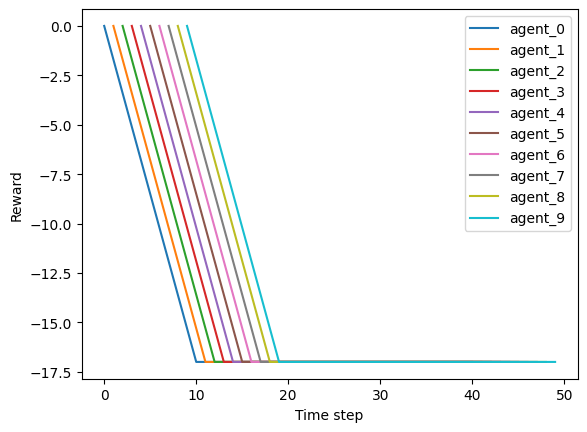

In [38]:
trajectory.groupby('agent')['reward'].plot(legend=True, xlabel='Time step', ylabel='Reward');

Text(0.5, 0, 'Time step')

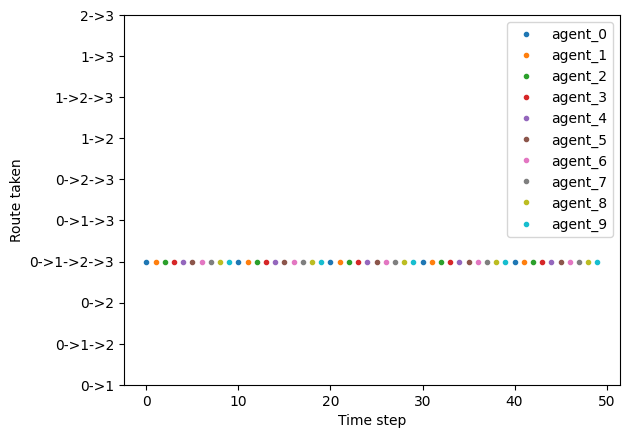

In [39]:
ax, *_ = trajectory.groupby('agent')['action'].plot(style='.', legend=True)
ax.set_yticks(list(route_indices.values()), [edge_path_to_node_path(route, edge_list) for route in route_indices.keys()]);
ax.set_ylabel('Route taken')
ax.set_xlabel('Time step')

## With governance

In [92]:
class TrafficRestrictor(Restrictor):
    def act(self, observation: Space) -> RestrictorActionSpace:
        return DiscreteVectorRestriction(self.action_space.base_space, allowed_actions=[True, True, True, True, True])

In [93]:
number_of_agents = 2

edge_list, edge_indices, edge_latencies, routes, route_list, route_indices = analyze_graph(graph)
number_of_edges = graph.number_of_edges()

agents = {f'agent_{i}': TrafficAgent(routes, route_indices, edge_indices) for i in range (number_of_agents)}
env = TrafficEnvironment(graph, list(agents), possible_routes, number_of_steps=100)

restrictor = TrafficRestrictor(Box(0, np.inf, shape=(number_of_edges, )), DiscreteVectorActionSpace(Discrete(len(routes))))
wrapper = RestrictionWrapper(env, restrictor, restrictor_reward_fns={'restrictor_0': lambda env, rewards: rewards[env.agent_selection]})

policies = {**{id: agent.act for id, agent in agents.items()}, 'restrictor_0': restrictor.act}

trajectory = play(wrapper, policies, max_iter=50, verbose=False, record_trajectory=True, render_mode=None)

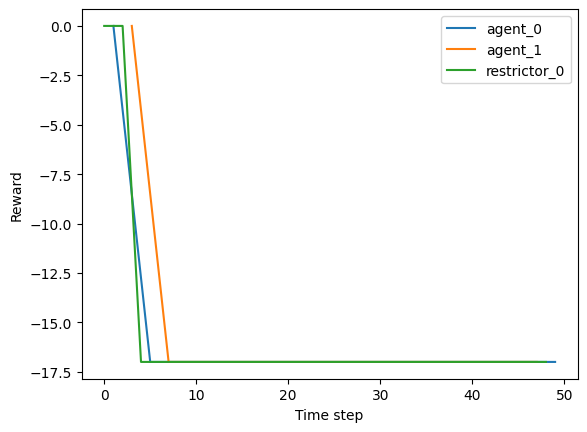

In [94]:
trajectory.groupby('agent')['reward'].plot(legend=True, xlabel='Time step', ylabel='Reward');

Text(0.5, 0, 'Time step')

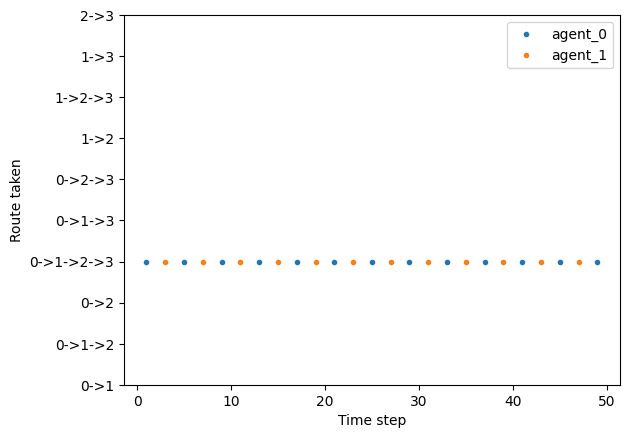

In [95]:
ax, *_ = trajectory[trajectory['agent'] != 'restrictor_0'].groupby('agent')['action'].plot(style='.', legend=True)
ax.set_yticks(list(route_indices.values()), [edge_path_to_node_path(route, edge_list) for route in route_indices.keys()]);
ax.set_ylabel('Route taken')
ax.set_xlabel('Time step')